In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
unchange_prompt = f'''Rewrite the following text by changing the wording but keeping all the facts exactly the same. The new version should match the original sentiment very closely, not just in positivity or negativity but also in the nuanced expression of emotions. Aim to minimize any changes that could alter the text's subtle tone, and ensure the paraphrased version is close in meaning to the original.'''
negative_prompt = f'''Please modify the following text to reflect a more negative or aggressive tone. \nRequirements: \n- Add around <<num_words>> negative or aggressive words;\n- Maintain the original structure as closely as possible;\n- Shift the underlying implications to convey a more hostile attitude.'''
positive_promt = f'''Please modify the following text to reflect a more positive, enthusiastic tone. \nRequirements: \n- Add or modify around <<num_words>> words; \n- Maintain the original structure as closely as possible; \n- Shift the language to convey excitement and optimism.'''

prompts = {'unchange': unchange_prompt, 'negative': negative_prompt, 'positive': positive_promt}

# Embedding Extraction

## lfqa

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import argparse
import pandas as pd
from datasets import load_dataset, Dataset
from tqdm import tqdm
from itertools import chain
import numpy as np
import os


In [2]:
# def _sentiment_embedding(input_text, model, tokenizer, device):
#     input_ids = tokenizer(input_text, return_tensors='pt', add_special_tokens=False, truncation=True, max_length=512).to(device)
#     # last hidden states shape is [batch_size, sequence_length, hidden_size]
#     # uses the hidden state of the [CLS] token (at index 0 along the sequence_length dimension)
#     outputs = model(**input_ids, output_hidden_states=True)['hidden_states'][-1][:, 0, :].squeeze()
#     return outputs

def _sentiment_embedding(input_text, model, tokenizer, device):
    input_ids = tokenizer(
        input_text,
        return_tensors='pt',
        # add_special_tokens=False,
        truncation=True,  # Truncate input to the model's max length
        max_length=512    # Ensure the max length is 512 for RoBERTa
    ).to(device)
    # last hidden states shape is [batch_size, sequence_length, hidden_size]
    with torch.no_grad():
        outputs = model(**input_ids, output_hidden_states=True, return_dict=True)
        # last_hidden = outputs.last_hidden_state
        pooler_output = outputs.pooler_output.squeeze()
    return pooler_output

# def _sentiment_embedding(input_text, model, tokenizer, device):
#     input_ids = tokenizer(
#         input_text,
#         return_tensors='pt',
#         # add_special_tokens=False,
#         truncation=True,  # Truncate input to the model's max length
#         max_length=512    # Ensure the max length is 512 for RoBERTa
#     ).to(device)
#     # last hidden states shape is [batch_size, sequence_length, hidden_size]
#     # uses the average hidden state of all tokens excluding special tokens
#     last_hidden_state = model(**input_ids, output_hidden_states=True)['hidden_states'][-1]
#     attention_mask = input_ids["attention_mask"]
#     special_tokens_mask = torch.tensor(
#         tokenizer.get_special_tokens_mask(input_ids["input_ids"][0].tolist(), already_has_special_tokens=True)
#     ).unsqueeze(0).cuda()
#     valid_token_mask = (attention_mask == 1) & (special_tokens_mask == 0)
#     valid_embeddings = last_hidden_state[valid_token_mask]
#     average_embedding = valid_embeddings.mean(dim=0)
#     return average_embedding


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-2gpu-64batch/checkpoint-epoch1"
sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-sentiment/checkpoint-125"
sentiment_model = AutoModel.from_pretrained(sentiment_model_name)
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
state_dict = torch.load(f'{sentiment_model_name}/pytorch_model.bin')
sentiment_model.pooler.dense.weight.data = state_dict['mlp.dense.weight'].clone()
sentiment_model.pooler.dense.bias.data = state_dict['mlp.dense.bias'].clone()
sentiment_model = sentiment_model.to(device)
sentiment_model.eval()

data_path = '/mnt/data2/lian/projects/watermark/data/lfqa_train.csv'
original_data = pd.read_csv(data_path)
# group rows with the same values in 'sent0' together by sorting
original_data = original_data.sort_values(by='sent0', ascending=True) 
original_data = original_data.reset_index(drop=True)

orig_text = original_data['sent0'].tolist()
para_text = original_data['sent1'].tolist()
neg_text = original_data['hard_neg'].tolist()

orig_data = Dataset.from_dict({'text': orig_text})
para_data = Dataset.from_dict({'text': para_text})
neg_data = Dataset.from_dict({'text': neg_text})

orig_embedding_list = []
para_embedding_list = []
neg_embedding_list = []

for i in tqdm(range(orig_data.num_rows)):
    orig_embedding_list.append(_sentiment_embedding(orig_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())
    para_embedding_list.append(_sentiment_embedding(para_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())
    neg_embedding_list.append(_sentiment_embedding(neg_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())

orig_embeddings = np.vstack(orig_embedding_list)
para_embeddings = np.vstack(para_embedding_list)
neg_embeddings = np.vstack(neg_embedding_list)

save_path = os.path.join('data', f'{sentiment_model_name.split("/")[-2]}', 'dense_output')
os.makedirs(save_path, exist_ok=True)
np.savetxt(os.path.join(save_path, 'orig_embeddings_sc.text'), orig_embeddings, delimiter=" ")
np.savetxt(os.path.join(save_path, 'para_embeddings_sc.text'), para_embeddings, delimiter=" ")
np.savetxt(os.path.join(save_path, 'neg_embeddings_sc.text'), neg_embeddings, delimiter=" ")


Construct evaluation set

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-2gpu-64batch/checkpoint-epoch1"
sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-sentiment/checkpoint-125"
sentiment_model = AutoModel.from_pretrained(sentiment_model_name)
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
state_dict = torch.load(f'{sentiment_model_name}/pytorch_model.bin')
sentiment_model.pooler.dense.weight.data = state_dict['mlp.dense.weight'].clone()
sentiment_model.pooler.dense.bias.data = state_dict['mlp.dense.bias'].clone()
sentiment_model = sentiment_model.to(device)
sentiment_model.eval()

data_path = '/mnt/data2/lian/projects/watermark/data/lfqa_test_final.csv'
original_data = pd.read_csv(data_path)

orig_text = original_data['text'].tolist()
para_text = original_data['unchange_paraphrase'].tolist()
neg_text = original_data['negative_paraphrase'].tolist()

orig_data = Dataset.from_dict({'text': orig_text})
para_data = Dataset.from_dict({'text': para_text})
neg_data = Dataset.from_dict({'text': neg_text})

orig_embedding_list = []
para_embedding_list = []
neg_embedding_list = []

for i in tqdm(range(orig_data.num_rows)):
    orig_embedding_list.append(_sentiment_embedding(orig_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())
    para_embedding_list.append(_sentiment_embedding(para_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())
    neg_embedding_list.append(_sentiment_embedding(neg_data[i]['text'], sentiment_model, sentiment_tokenizer, device).unsqueeze(0).detach().cpu().numpy())

orig_embeddings = np.vstack(orig_embedding_list)
para_embeddings = np.vstack(para_embedding_list)
neg_embeddings = np.vstack(neg_embedding_list)

os.makedirs(os.path.join(save_path, 'valid'), exist_ok=True)
np.savetxt(os.path.join(save_path, 'valid', 'orig_embeddings_sc.text'), orig_embeddings, delimiter=" ")
np.savetxt(os.path.join(save_path, 'valid', 'para_embeddings_sc.text'), para_embeddings, delimiter=" ")
np.savetxt(os.path.join(save_path, 'valid', 'neg_embeddings_sc.text'), neg_embeddings, delimiter=" ")


# Training

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import numpy as np
import os
import argparse
from torch.optim import lr_scheduler
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(dim, dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = out + x 
        return out

class TransformModel(nn.Module):
    def __init__(self, num_layers=4, input_dim=768, hidden_dim=512, output_dim=384):
        super(TransformModel, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        
        for _ in range(num_layers - 2):
            self.layers.append(ResidualBlock(hidden_dim))

        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

class VectorDataset(Dataset):
    def __init__(self, vectors):
        self.vectors = vectors
    
    def __len__(self):
        return len(self.vectors)
    
    def __getitem__(self, idx):
        return self.vectors[idx]


def sequence_similarity(x, y):
    # euclidean distance
    matches = torch.sqrt(torch.sum((x-y)**2, dim=-1))
    return matches

def sign_loss(x, factor):
    smooth_sign = torch.tanh(x*factor)
    row = torch.abs(torch.mean(torch.mean(smooth_sign, dim=0)))
    col = torch.abs(torch.mean(torch.mean(smooth_sign, dim=1)))
    return (row + col)/2

def loss_fn(
        output_a, 
        output_b, 
        input_a, 
        input_b, 
        output_a_para, 
        output_a_neg,
        lambda_1,
        lambda_2,
        lambda_3,
        lambda_4,
        ):
    
    s = sequence_similarity(input_a, input_b)
    t_s = sequence_similarity(output_a, output_b)

    min_orig, max_orig, min_new, max_new = 0, 2, -2, 4
    s = (s - min_orig) / (max_orig - min_orig) * (max_new - min_new) + min_new

    loss_1 = torch.abs(s - t_s).mean()
    loss_2 = (sign_loss(output_a, 1000) + sign_loss(output_b, 1000))/2
    loss_3 = torch.abs(sequence_similarity(output_a, output_a_para)).mean()
    loss_4 = -torch.abs(sequence_similarity(output_a, output_a_neg)).mean()
    
    total_loss = lambda_1*loss_1 + lambda_2*loss_2 + lambda_3*loss_3 + lambda_4*torch.clamp(loss_4, min=-4)
    
    if lambda_4 == 0:
        loss_4 = None
    return total_loss, loss_1, loss_2, loss_3 , loss_4

def normalize_array(array):
    row_norms = np.linalg.norm(array, axis=1, keepdims=True)
    assert np.all(row_norms > 0), "There are rows with zero norm in the array!"
    array_norm = array / row_norms
    return array_norm

def parser(args=None):
    parser = argparse.ArgumentParser(description="Train watermark model")
    parser.add_argument("--orig_input_file", type=str, default="orig_embeddings_sc.text")
    parser.add_argument("--para_input_file", type=str, default="para_embeddings_sc.text")
    parser.add_argument("--neg_input_file", type=str, default="neg_embeddings_sc.text")
    parser.add_argument("--output_model", type=str, default="transform_model.pth")
    parser.add_argument("--epochs", type=int, default=1000)
    parser.add_argument("--lr", type=float, default=1e-5)
    parser.add_argument("--input_dim", type=int, default=768)

    args = parser.parse_args(args=args)
    return args


DATA_DIR = r"data/my-sup-simcse-roberta-base-sentiment/dense_output"
MODEL_DIR = "model/my-sup-simcse-roberta-base-sentiment/dense_output"
os.makedirs(MODEL_DIR, exist_ok=True)

args = parser(['--epochs', '500',
               '--lr', '1e-5',
               '--output_model', 'transform_model_1.pth'])
print(args)


Namespace(orig_input_file='orig_embeddings_sc.text', para_input_file='para_embeddings_sc.text', neg_input_file='neg_embeddings_sc.text', output_model='transform_model_1.pth', epochs=500, lr=1e-05, input_dim=768)


In [3]:
def data_prepare(args, data_dir):
    orig_embedding_file = os.path.join(data_dir, args.orig_input_file)
    para_embedding_file = os.path.join(data_dir, args.para_input_file)
    neg_embedding_file = os.path.join(data_dir, args.neg_input_file)
    
    orig_embedding_data = np.loadtxt(orig_embedding_file)
    para_embedding_data = np.loadtxt(para_embedding_file)
    neg_embedding_data = np.loadtxt(neg_embedding_file)

    # Normalize
    orig_embedding_data_norm = normalize_array(orig_embedding_data)
    para_embedding_data_norm = normalize_array(para_embedding_data)
    neg_embedding_data_norm = normalize_array(neg_embedding_data)

    total_data = orig_embedding_data_norm.shape[0]
    orig_embedding_data_norm = orig_embedding_data_norm[:total_data//2*2]

    orig_data_1 = torch.tensor(orig_embedding_data_norm[:total_data//2], device='cuda', dtype=torch.float32)
    orig_data_2 = torch.tensor(orig_embedding_data_norm[total_data//2:], device='cuda', dtype=torch.float32)
    para_data = torch.tensor(para_embedding_data_norm[:total_data//2], device='cuda', dtype=torch.float32)
    neg_data = torch.tensor(neg_embedding_data_norm[:total_data//2], device='cuda', dtype=torch.float32)

    orig_dataset_1 = VectorDataset(orig_data_1)
    orig_dataset_2 = VectorDataset(orig_data_2)
    para_dataset = VectorDataset(para_data)
    neg_dataset = VectorDataset(neg_data)

    orig_dataloader_1 = DataLoader(orig_dataset_1, batch_size=128, shuffle=False)
    orig_dataloader_2 = DataLoader(orig_dataset_2, batch_size=128, shuffle=False)
    para_dataloader = DataLoader(para_dataset, batch_size=128, shuffle=False)
    neg_dataloader = DataLoader(neg_dataset, batch_size=128, shuffle=False)

    return orig_dataloader_1, orig_dataloader_2, para_dataloader, neg_dataloader

orig_dataloader_1, orig_dataloader_2, para_dataloader, neg_dataloader = data_prepare(args, DATA_DIR)
valid_orig_dataloader_1, valid_orig_dataloader_2, valid_para_dataloader, valid_neg_dataloader = data_prepare(args, os.path.join(DATA_DIR, 'valid'))

## Train from scratch

In [9]:
def print_loss(loss, loss_1, loss_2, loss_3, loss_4):
    output = f"Loss: {round(loss, 4)}, Loss_1: {round(loss_1, 2)}, Loss_2: {round(loss_2, 2)}, Loss_3: {round(loss_3, 2)}"
    if loss_4:
        output += f", Loss_4: {round(loss_4, 2)}"
    return output

In [ ]:
epochs = 500
lr=5e-4
step_size=500
weight_decay=1e-4
lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 3.0, 0.0

model = TransformModel(input_dim=args.input_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4 = float('inf'), 0, 0, 0, 0  # Initialize the best validation loss to infinity
best_val_epoch = 0
loss_name = '4loss' if lambda_4 != 0.0 else '3loss'
os.makedirs(os.path.join(MODEL_DIR, f"{loss_name}", "scratch"), exist_ok=True)
best_model_path = os.path.join(MODEL_DIR, f"{loss_name}", "scratch", "best_model.pth")  # lambda{lambda_1}|{lambda_2}|{lambda_3}|{lambda_4}_lr{lr}_
final_model_path = os.path.join(MODEL_DIR, f"{loss_name}", "scratch", "final_model.pth")

for epoch in range(epochs):
    model.train()
    orig_iter_1 = iter(orig_dataloader_1)
    orig_iter_2 = iter(orig_dataloader_2)
    para_iter = iter(para_dataloader)
    neg_iter = iter(neg_dataloader)

    for _ in range(len(orig_dataloader_1)):
        input_a = next(orig_iter_1).to(device)
        input_b = next(orig_iter_2).to(device)
        input_c = next(para_iter).to(device)
        input_d = next(neg_iter).to(device)

        output_a = model(input_a)
        output_b = model(input_b)
        output_c = model(input_c)
        output_d = model(input_d)

        loss, loss_1, loss_2, loss_3, loss_4 = loss_fn(output_a, output_b, input_a, input_b, output_c, output_d, lambda_1, lambda_2, lambda_3, lambda_4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if _ % 100 == 0:
            loss_4_ = loss_4.item() if loss_4 else None
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{_ + 1}/{len(orig_dataloader_1)}], {print_loss(loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), loss_4_)}")
            
    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        num_batches = 0
        total_loss, total_loss_1, total_loss_2, total_loss_3, total_loss_4 = 0, 0, 0, 0, 0

        for (input_a, input_b, para, neg) in zip(
            valid_orig_dataloader_1, valid_orig_dataloader_2, valid_para_dataloader, valid_neg_dataloader
        ):
            input_a, input_b = input_a.to(device), input_b.to(device)
            para, neg = para.to(device), neg.to(device)

            output_a = model(input_a)
            output_b = model(input_b)
            output_a_para = model(para)
            output_a_neg = model(neg)

            loss, loss_1, loss_2, loss_3, loss_4 = loss_fn(
                output_a, output_b, input_a, input_b, output_a_para, output_a_neg,
                lambda_1, lambda_2, lambda_3, lambda_4
            )

            total_loss += loss.item()
            total_loss_1 += loss_1.item()
            total_loss_2 += loss_2.item()
            total_loss_3 += loss_3.item()
            if loss_4:
                total_loss_4 += loss_4.item()
            num_batches += 1

        avg_val_loss = total_loss / num_batches
        avg_val_loss_1 = total_loss_1 / num_batches
        avg_val_loss_2 = total_loss_2 / num_batches
        avg_val_loss_3 = total_loss_3 / num_batches
        avg_val_loss_4 = total_loss_4 / num_batches
        print(f"Validation {print_loss(avg_val_loss, avg_val_loss_1, avg_val_loss_2, avg_val_loss_3, avg_val_loss_4)}")

        # Save the model if it's the best so far
        if avg_val_loss < best_val_loss:
            best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4 = avg_val_loss, avg_val_loss_1, avg_val_loss_2, avg_val_loss_3, avg_val_loss_4
            best_val_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")

    scheduler.step()  # Update the learning rate if using a scheduler

torch.save(model.state_dict(), final_model_path)
print(f"Training complete. Final model saved at: {final_model_path}")
print(f"Best validation appeared at epoch {best_val_epoch}, {print_loss(best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4)}")


roberta-base-sentiment; dense output

**3** loss; train from scratch

best hyper-parameter:

epochs = 500

lr=5e-4

step_size=500

weight_decay=1e-4

lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 3.0, 0.0

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

Best validation appeared at epoch 499, Loss: 1.4477, Loss_1: 1.05, Loss_2: 0.01, Loss_3: 0.13


roberta-base-sentiment; dense output

**4** loss; train from scratch

best hyper-parameter:

epochs = 500

lr=1e-4

step_size=500

weight_decay=1e-4

lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 2.0, 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

Best validation appeared at epoch 499, Loss: 0.8471, Loss_1: 1.1, Loss_2: 0.01, Loss_3: 0.16, Loss_4: -1.16


## Fineturn + Evaluate

In [33]:
def print_loss(loss, loss_1, loss_2, loss_3, loss_4):
    output = f"Loss: {round(loss, 4)}, Loss_1: {round(loss_1, 2)}, Loss_2: {round(loss_2, 2)}, Loss_3: {round(loss_3, 2)}"
    if loss_4:
        output += f", Loss_4: {round(loss_4, 2)}"
    return output

In [ ]:
epochs = 500
lr=1e-4
step_size=500
weight_decay=1e-4
lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 2.0, 0.5

model = TransformModel(input_dim=args.input_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

pretrained_path = r'/mnt/data2/lian/projects/watermark/adaptive-text-watermark-yepeng/model/semantic_mapping_model.pth'
model.load_state_dict(torch.load(pretrained_path, map_location=device))

best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4 = float('inf'), 0, 0, 0, 0  # Initialize the best validation loss to infinity
best_val_epoch = 0
loss_name = '4loss' if lambda_4 != 0.0 else '3loss'
os.makedirs(os.path.join(MODEL_DIR, f"{loss_name}", "finetune"), exist_ok=True)
best_model_path = os.path.join(MODEL_DIR, f"{loss_name}", "finetune", "best_model.pth")  # lambda{lambda_1}|{lambda_2}|{lambda_3}|{lambda_4}_lr{lr}_
final_model_path = os.path.join(MODEL_DIR, f"{loss_name}", "finetune", "final_model.pth")

for epoch in range(epochs):
    model.train()  # Set model to training mode
    orig_iter_1 = iter(orig_dataloader_1)
    orig_iter_2 = iter(orig_dataloader_2)
    para_iter = iter(para_dataloader)
    neg_iter = iter(neg_dataloader)

    for _ in range(len(orig_dataloader_1)):
        input_a = next(orig_iter_1).to(device)
        input_b = next(orig_iter_2).to(device)
        input_c = next(para_iter).to(device)
        input_d = next(neg_iter).to(device)

        output_a = model(input_a)
        output_b = model(input_b)
        output_c = model(input_c)
        output_d = model(input_d)

        loss, loss_1, loss_2, loss_3, loss_4 = loss_fn(output_a, output_b, input_a, input_b, output_c, output_d, lambda_1, lambda_2, lambda_3, lambda_4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if _ % 100 == 0:
            loss_4_ = loss_4.item() if loss_4 else None
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{_ + 1}/{len(orig_dataloader_1)}], {print_loss(loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), loss_4_)}")

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        num_batches = 0
        total_loss, total_loss_1, total_loss_2, total_loss_3, total_loss_4 = 0, 0, 0, 0, 0

        for (input_a, input_b, para, neg) in zip(
            valid_orig_dataloader_1, valid_orig_dataloader_2, valid_para_dataloader, valid_neg_dataloader
        ):
            input_a, input_b = input_a.to(device), input_b.to(device)
            para, neg = para.to(device), neg.to(device)

            output_a = model(input_a)
            output_b = model(input_b)
            output_a_para = model(para)
            output_a_neg = model(neg)

            loss, loss_1, loss_2, loss_3, loss_4 = loss_fn(
                output_a, output_b, input_a, input_b, output_a_para, output_a_neg,
                lambda_1, lambda_2, lambda_3, lambda_4
            )

            total_loss += loss.item()
            total_loss_1 += loss_1.item()
            total_loss_2 += loss_2.item()
            total_loss_3 += loss_3.item()
            if loss_4:
                total_loss_4 += loss_4.item()
            num_batches += 1

        avg_val_loss = total_loss / num_batches
        avg_val_loss_1 = total_loss_1 / num_batches
        avg_val_loss_2 = total_loss_2 / num_batches
        avg_val_loss_3 = total_loss_3 / num_batches
        avg_val_loss_4 = total_loss_4 / num_batches
        print(f"Validation {print_loss(avg_val_loss, avg_val_loss_1, avg_val_loss_2, avg_val_loss_3, avg_val_loss_4)}")

        # Save the model if it's the best so far
        if avg_val_loss < best_val_loss:
            best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4 = avg_val_loss, avg_val_loss_1, avg_val_loss_2, avg_val_loss_3, avg_val_loss_4
            best_val_epoch = epoch
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")

    scheduler.step()  # Update the learning rate if using a scheduler

# Save the final model
torch.save(model.state_dict(), final_model_path)
print(f"Training complete. Final model saved at: {final_model_path}")
print(f"Best validation appeared at epoch {best_val_epoch}, {print_loss(best_val_loss, best_val_loss_1, best_val_loss_2, best_val_loss_3, best_val_loss_4)}")


roberta-base-sentiment; dense output

**4** loss; finetune

best hyper-parameter:

epochs = 500

lr=1e-4

step_size=500

weight_decay=1e-4

lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 2.0, 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

Best validation appeared at epoch 499, Loss: 1.0305, Loss_1: 1.17, Loss_2: 0.01, Loss_3: 0.14, Loss_4: -1.02



roberta-base-sentiment; dense output

**3** loss; finetune

best hyper-parameter:

epochs = 500

lr=3e-4

step_size=500

weight_decay=1e-5

lambda_1, lambda_2, lambda_3, lambda_4 = 1.0, 1.0, 1.0, 0.0

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.8)

Best validation appeared at epoch 498, Loss: 1.302, Loss_1: 1.13, Loss_2: 0.01, Loss_3: 0.16


**Best 3 loss results:**

epochs = 500

lr=1e-3

step_size=100

weight_decay=1e-3

lambda_1, lambda_2, lambda_3, lambda_4 = 2.0, 1.0, 1.0, 0

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

Best validation appeared at epoch 498, Loss: 1.0072, Loss_1: 0.41, Loss_2: 0.03, Loss_3: 0.16


**Best 4 loss results:**

epochs = 500

lr=1e-3

step_size=70

weight_decay=1e-3

lambda_1, lambda_2, lambda_3, lambda_4 = 2.0, 1.0, 2.0, 0.5

scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

Best validation appeared at epoch 498, Loss: 0.2527, Loss_1: 0.65, Loss_2: 0.01, Loss_3: 0.43, Loss_4: -3.82



# Exploration

In [ ]:
ori_mins, ori_maxs= [], []

orig_iter_1 = iter(orig_dataloader_1)
orig_iter_2 = iter(orig_dataloader_2)

for _ in range(len(orig_dataloader_1)):
    input_a = next(orig_iter_1).to(device)
    input_b = next(orig_iter_2).to(device)

    s = sequence_similarity(input_a, input_b)
    ori_maxs.append(s.max().item())
    ori_mins.append(s.min().item())

print('original min:', min(ori_mins), 'max:', max(ori_maxs))

In [ ]:
import pandas as pd
data_path = '/mnt/data2/lian/projects/watermark/data/lfqa_train.csv'
original_data = pd.read_csv(data_path)

original_data['sent0'].unique().shape

In [ ]:
original_data.shape

In [ ]:
import pandas as pd
data_path = '/mnt/data2/lian/projects/watermark/data/lfqa_train.csv'
original_data = pd.read_csv(data_path)

# group rows with the same values in 'sent0' together by sorting
original_data = original_data.sort_values(by='sent0', ascending=True) 
original_data = original_data.reset_index(drop=True)

total_data = original_data.shape[0]
original_data = original_data[:total_data//2*2]

orig_data_1 = original_data[:total_data//2]
orig_data_2 = original_data[total_data//2:]

overlap = set(orig_data_1['sent0']) & set(orig_data_2['sent0'])
if overlap:
    print("Overlap values:", overlap)
else:
    print("No overlap found.")


## explore detection

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load sentiment embedding model
# sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-2gpu-64batch/checkpoint-epoch1"
sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-sentiment/checkpoint-125"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name, device_map='auto')
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)


In [7]:
text = 'how are you'
sentiment_embed = _sentiment_embedding(text, sentiment_model, sentiment_tokenizer, device)

In [ ]:
sentiment_embed[:10]

## visualize similarity after mapping

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from tqdm import tqdm
import os

unchange_prompt = f'''Rewrite the following text by changing the wording but keeping all the facts exactly the same. The new version should match the original sentiment very closely, not just in positivity or negativity but also in the nuanced expression of emotions. Aim to minimize any changes that could alter the text's subtle tone, and ensure the paraphrased version is close in meaning to the original.'''
negative_prompt = f'''Please modify the following text to reflect a more negative or aggressive tone. \nRequirements: \n- Add around <<num_words>> negative or aggressive words;\n- Maintain the original structure as closely as possible;\n- Shift the underlying implications to convey a more hostile attitude.'''
positive_promt = f'''Please modify the following text to reflect a more positive, enthusiastic tone. \nRequirements: \n- Add or modify around <<num_words>> words; \n- Maintain the original structure as closely as possible; \n- Shift the language to convey excitement and optimism.'''

prompts = {'unchange': unchange_prompt, 'negative': negative_prompt, 'positive': positive_promt}

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(dim, dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = out + x 
        return out

class SemanticModel(nn.Module):
    def __init__(self, num_layers=2, input_dim=768, hidden_dim=512, output_dim=384):
        super(SemanticModel, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        
        for _ in range(num_layers):
            self.layers.append(ResidualBlock(hidden_dim))

        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        
        return x


In [13]:
def _semantic_embedding(input_text, model):
    outputs = model.encode(input_text, convert_to_tensor=True)
    return outputs

In [14]:
import torch.nn.functional as F
import math

def cosine_similarity(list1, list2):
    assert len(list1) == len(list2), "Lists must have the same length"
    dot_product = sum(el1 * el2 for el1, el2 in zip(list1, list2))
    norm1 = math.sqrt(sum(el1**2 for el1 in list1))
    norm2 = math.sqrt(sum(el2**2 for el2 in list2))
    return dot_product / (norm1 * norm2) if norm1 != 0 and norm2 != 0 else 0


def _compute_mapping_similarity(original_text, paraphrased_text, embed_model, map_model, embed_tokenizer=None, sign_transform=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if embed_tokenizer: 
        # sentiment embedding
        original_embed = _sentiment_embedding(original_text, embed_model, embed_tokenizer, device)
        paraphrased_embed = _sentiment_embedding(paraphrased_text, embed_model, embed_tokenizer, device)
    else:
        # semantic embedding
        original_embed = _semantic_embedding(original_text, embed_model)
        paraphrased_embed = _semantic_embedding(paraphrased_text, embed_model)

    original_map = map_model(original_embed)
    paraphrased_map = map_model(paraphrased_embed)

    if sign_transform:
        original_map = original_map.tolist()
        original_map = [1.0 if x>0.0 else 0.0 for x in original_map]
        paraphrased_map = paraphrased_map.tolist()
        paraphrased_map = [1.0 if x>0.0 else 0.0 for x in paraphrased_map]
        cosine_sim_value = cosine_similarity(original_map, paraphrased_map)
    else:
        cosine_sim = F.cosine_similarity(original_map.unsqueeze(0), paraphrased_map.unsqueeze(0), dim=1)
        cosine_sim_value = cosine_sim.item()

    return cosine_sim_value


### compare similarity between original text and attacked on **watermarked text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load sentiment embedding model
# sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-2gpu-64batch/checkpoint-epoch1"
sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-sentiment/checkpoint-125"
sentiment_model = AutoModel.from_pretrained(sentiment_model_name)
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
state_dict = torch.load(f'{sentiment_model_name}/pytorch_model.bin')
sentiment_model.pooler.dense.weight.data = state_dict['mlp.dense.weight'].clone()
sentiment_model.pooler.dense.bias.data = state_dict['mlp.dense.bias'].clone()
sentiment_model = sentiment_model.to(device)
sentiment_model.eval()

def compute_mapping_similarity(mapping_model_name, sign_transform=False):
    # load semantic mapping model
    mapping_model = SemanticModel()
    mapping_model.load_state_dict(torch.load(mapping_model_name))
    mapping_model.to(device)
    mapping_model.eval()

    data_dir = os.path.dirname(mapping_model_name)
    df_result = pd.DataFrame()

    for attack in ['hate', 'paraphrase']:
        data_path = f'{data_dir}/{attack}-8b-10sent-alpha2.0-beta1.0-delta0.2|0.5.csv'
        data = pd.read_csv(data_path)
        df_result[f'{attack}_similarity'] = ''
        for i in tqdm(range(data.shape[0])):
            original = data.loc[i, 'original_text']
            paraphrased =  data.loc[i, f'{attack}_watermarked_text']
            if isinstance(paraphrased, str):  # paraphrased text is not empty
                similarity = _compute_mapping_similarity(original, paraphrased, sentiment_model, mapping_model, embed_tokenizer=sentiment_tokenizer, sign_transform=sign_transform)
            else:
                similarity = None
            df_result.loc[i, f"{attack}_similarity"] = similarity
    return df_result


In [ ]:
mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/scratch/best_model.pth"
loss4_scratch = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/finetune/best_model.pth"
loss4_finetune = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/scratch/best_model.pth"
loss3_scratch = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/finetune/best_model.pth"
loss3_finetune = compute_mapping_similarity(mapping_model_name, sign_transform=True)

import matplotlib.pyplot as plt

for col in ['paraphrase_similarity', 'hate_similarity']:
# Extracting the 'unchange_similarity' columns from the given dataframes
    data1 = loss4_scratch[col]
    data2 = loss4_finetune[col]
    data3 = loss3_scratch[col]
    data4 = loss3_finetune[col]

    # Handling None values by filtering them out
    data1 = [value for value in data1 if value is not None]
    data2 = [value for value in data2 if value is not None]
    data3 = [value for value in data3 if value is not None]
    data4 = [value for value in data4 if value is not None]

    # Creating the boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([data1, data2, data3, data4], labels=['loss4_scratch', 'loss4_finetune', 'loss3_scratch', 'loss3_finetune'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'))

    # Adding title and labels
    plt.title(f'Similarity of Mapping after 0/1 Transfromation for {col}')
    plt.ylabel('Similarity')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()


In [ ]:
loss='4loss'
train='finetune'
mapping_model_name=rf"model/my-sup-simcse-roberta-base-sentiment/dense_output/{loss}/{train}/best_model.pth"
df_result = compute_mapping_similarity(mapping_model_name, sign_transform=True)

df_long = pd.melt(df_result[['paraphrase_similarity', 'hate_similarity']], 
                  var_name='Similarity Type', value_name='Similarity')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Similarity Type', y='Similarity', data=df_long)

plt.title(f"{loss}/{train} Similarity of Mapping after 0/1 Transfromation", fontsize=15)
plt.xlabel('Paraphrase Type')
plt.ylabel('Similarity')
plt.xticks(rotation=30)

# 显示图表
plt.show()
print('Complete!')


### compare similarity between original text and attacked on **original text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load sentiment embedding model
# sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-2gpu-64batch/checkpoint-epoch1"
sentiment_model_name = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-simcse-roberta-base-sentiment/checkpoint-125"
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name, device_map='auto')
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)

def compute_mapping_similarity(mapping_model_name, sign_transform=False):
    # load semantic mapping model
    mapping_model = SemanticModel()
    mapping_model.load_state_dict(torch.load(mapping_model_name))
    mapping_model.to(device)
    mapping_model.eval()

    # load dataset
    test_data_final = r'/mnt/data2/lian/projects/watermark/data/c4_test_final.csv'
    df_test_final = pd.read_csv(test_data_final)

    # calculate similarity between embeddings
    for type_ in prompts.keys():
        df_test_final[f"{type_}_similarity"] = ''
        for i in tqdm(range(df_test_final.shape[0])):
            original = df_test_final.loc[i, 'text']
            paraphrased =  df_test_final.loc[i, f'{type_}_paraphrase']
            similarity = _compute_mapping_similarity(original, paraphrased, sentiment_model, mapping_model, embed_tokenizer=sentiment_tokenizer, sign_transform=sign_transform)
            df_test_final.loc[i, f"{type_}_similarity"] = similarity
    return df_test_final


In [ ]:
mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/scratch/best_model.pth"
loss4_scratch = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/finetune/best_model.pth"
loss4_finetune = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/scratch/best_model.pth"
loss3_scratch = compute_mapping_similarity(mapping_model_name, sign_transform=True)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/finetune/best_model.pth"
loss3_finetune = compute_mapping_similarity(mapping_model_name, sign_transform=True)

import matplotlib.pyplot as plt

for col in ['unchange_similarity', 'negative_similarity', 'positive_similarity']:
# Extracting the 'unchange_similarity' columns from the given dataframes
    data1 = loss4_scratch[col]
    data2 = loss4_finetune[col]
    data3 = loss3_scratch[col]
    data4 = loss3_finetune[col]

    # Creating the boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([data1, data2, data3, data4], labels=['loss4_scratch', 'loss4_finetune', 'loss3_scratch', 'loss3_finetune'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'))

    # Adding title and labels
    plt.title(f'Similarity of Mapping after 0/1 Transfromation for {col}')
    plt.ylabel('Similarity')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()


In [ ]:
mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/scratch/best_model.pth"
loss4_scratch = compute_mapping_similarity(mapping_model_name)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/4loss/finetune/best_model.pth"
loss4_finetune = compute_mapping_similarity(mapping_model_name)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/scratch/best_model.pth"
loss3_scratch = compute_mapping_similarity(mapping_model_name)

mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/finetune/best_model.pth"
loss3_finetune = compute_mapping_similarity(mapping_model_name)

import matplotlib.pyplot as plt

for col in ['unchange_similarity', 'negative_similarity', 'positive_similarity']:
# Extracting the 'unchange_similarity' columns from the given dataframes
    data1 = loss4_scratch[col]
    data2 = loss4_finetune[col]
    data3 = loss3_scratch[col]
    data4 = loss3_finetune[col]

    # Creating the boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot([data1, data2, data3, data4], labels=['loss4_scratch', 'loss4_finetune', 'loss3_scratch', 'loss3_finetune'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'), 
                medianprops=dict(color='red'))

    # Adding title and labels
    plt.title(f'Similarity of Mapping for {col}')
    plt.ylabel('Similarity')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()


### backup

In [ ]:
mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/finetune/best_model.pth"

df_test_final = compute_mapping_similarity(mapping_model_name, sign_transform=True)

df_long = pd.melt(df_test_final[['unchange_similarity', 'negative_similarity', 'positive_similarity']], 
                  var_name='Similarity Type', value_name='Similarity')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Similarity Type', y='Similarity', data=df_long)

plt.title(f"Similarity of Mapping after 0/1 Transfromation", fontsize=20)
plt.xlabel('Paraphrase Type')
plt.ylabel('Similarity')
plt.xticks(rotation=30)

# 显示图表
plt.show()
print('Complete!')


In [ ]:
mapping_model_name=r"model/my-sup-simcse-roberta-base-sentiment/dense_output/3loss/finetune/best_model.pth"

df_test_final = compute_mapping_similarity(mapping_model_name)

df_long = pd.melt(df_test_final[['unchange_similarity', 'negative_similarity', 'positive_similarity']], 
                  var_name='Similarity Type', value_name='Similarity')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Similarity Type', y='Similarity', data=df_long)

plt.title(f"Similarity of Mapping", fontsize=23)
plt.xlabel('Paraphrase Type')
plt.ylabel('Similarity')
plt.xticks(rotation=30)

# 显示图表
plt.show()
print('Complete!')


## Embed+Map integrated model Eval

load model

In [6]:
import os
import torch
from types import SimpleNamespace
from transformers import AutoConfig, AutoTokenizer
from model_cl2 import RobertaForCL
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_map_model_path = r"/mnt/data2/lian/projects/watermark/SimCSE/result/end2end-simcse-roberta-sentiment-c4-loss_cl2_gr-wneg64"
model_args = SimpleNamespace(
    temp = 0.05,
    pooler_type = 'cls',
    hard_negative_weight = math.log(64),
    do_mlm = False,
    mlp_only_train = False,
    freeze_roberta = True,
)

config = AutoConfig.from_pretrained(os.path.join(embed_map_model_path, "config.json"))
tokenizer = AutoTokenizer.from_pretrained(embed_map_model_path)
model = RobertaForCL.from_pretrained(
    embed_map_model_path,
    from_tf=bool(".ckpt" in embed_map_model_path),
    config=config,
    model_args=model_args,
    device_map='auto',
)
model.eval()

# if "twitter-roberta-base-sentiment" in model_args.embed_map_model_path:
#     # Initialize MLP weights
#     from transformers import AutoModelForSequenceClassification
#     pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_args.embed_map_model_path)
#     model.initialize_mlp_weights(pretrained_model)
#     print('Load mlp dense weights and bias from pretrained model!')


RobertaForCL(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [7]:
# compare with loading directly

# import torch
# embed_map_model_path = r"/mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-wm-simcse-roberta-sentiment-test"
# state_dict = torch.load(f'{embed_map_model_path}/pytorch_model.bin')


get mapping result

In [8]:
def _sentiment_embed_map(input_text, model, tokenizer, device):
    input_ids = tokenizer(
        input_text,
        return_tensors='pt',
        truncation=True,  # Truncate input to the model's max length
        max_length=512    # Ensure the max length is 512 for RoBERTa
    ).to(device)
    # last hidden states shape is [batch_size, sequence_length, hidden_size]
    with torch.no_grad():
        outputs = model(**input_ids, return_dict=True, sent_emb=True)
        pooler_output = outputs.pooler_output.squeeze()
    return pooler_output

In [9]:
import torch.nn.functional as F
import math

def cosine_similarity(list1, list2):
    assert len(list1) == len(list2), "Lists must have the same length"
    dot_product = sum(el1 * el2 for el1, el2 in zip(list1, list2))
    norm1 = math.sqrt(sum(el1**2 for el1 in list1))
    norm2 = math.sqrt(sum(el2**2 for el2 in list2))
    return dot_product / (norm1 * norm2) if norm1 != 0 and norm2 != 0 else 0


def _compute_mapping_similarity(original_text, paraphrased_text, embed_map_model, embed_map_tokenizer, sign_transform=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    original_map = _sentiment_embed_map(original_text, embed_map_model, embed_map_tokenizer, device)
    paraphrased_map = _sentiment_embed_map(paraphrased_text, embed_map_model, embed_map_tokenizer, device)

    if sign_transform:
        original_map = original_map.tolist()
        original_map = [1.0 if x>0.0 else 0.0 for x in original_map]
        paraphrased_map = paraphrased_map.tolist()
        paraphrased_map = [1.0 if x>0.0 else 0.0 for x in paraphrased_map]
        cosine_sim_value = cosine_similarity(original_map, paraphrased_map)
    else:
        cosine_sim = F.cosine_similarity(original_map.unsqueeze(0), paraphrased_map.unsqueeze(0), dim=1)
        cosine_sim_value = cosine_sim.item()

    return cosine_sim_value


### compare similarity between original text and attacked on **original text**

In [26]:
import pandas as pd

test_data_path = r"/mnt/data2/lian/projects/watermark/data/c4_test_final.csv"
df = pd.read_csv(test_data_path)
df['original_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df['neg_len'] = df['negative_paraphrase'].apply(lambda x: len(x.split(' ')))

In [27]:
import pandas as pd
from tqdm import tqdm

def compute_mapping_similarity(embed_map_model, embed_map_tokenizer, sign_transform=False):
    # load dataset
    test_data_final = r'/mnt/data2/lian/projects/watermark/data/c4_test_final.csv'
    df_test_final = pd.read_csv(test_data_final)

    # calculate similarity between embeddings
    for type_ in prompts.keys():
        df_test_final[f"{type_}_similarity"] = ''
        for i in tqdm(range(df_test_final.shape[0])):
            original = df_test_final.loc[i, 'text']
            paraphrased =  df_test_final.loc[i, f'{type_}_paraphrase']
            similarity = _compute_mapping_similarity(original, paraphrased, embed_map_model, embed_map_tokenizer, sign_transform=sign_transform)
            df_test_final.loc[i, f"{type_}_similarity"] = similarity
    return df_test_final


100%|██████████| 50/50 [00:01<00:00, 28.02it/s]


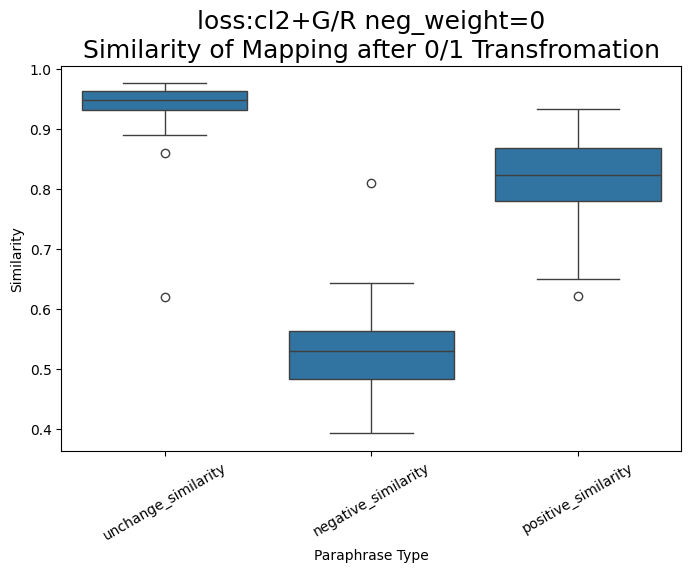

Complete!


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

df_test_final = compute_mapping_similarity(model, tokenizer, sign_transform=True)

df_long = pd.melt(df_test_final[['unchange_similarity', 'negative_similarity', 'positive_similarity']], 
                  var_name='Similarity Type', value_name='Similarity')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Similarity Type', y='Similarity', data=df_long)

plt.title(f"loss:cl2+G/R neg_weight=0\nSimilarity of Mapping after 0/1 Transfromation", fontsize=18)
plt.xlabel('Paraphrase Type')
plt.ylabel('Similarity')
plt.xticks(rotation=30)

# 显示图表
plt.show()
print('Complete!')


### compare similarity between original text and attacked on **watermarked text**

In [10]:
import pandas as pd
from tqdm import tqdm

def compute_mapping_similarity(embed_map_model, embed_map_tokenizer, sign_transform=False):
    df_result = pd.DataFrame()

    for attack in ['hate', 'paraphrased']:
        data_path = f'/mnt/data2/lian/projects/watermark/adaptive-text-watermark-yepeng/outputs/end2end/watermark-8b-loss_cl2_gr_wneg64-10sent-alpha2.0-delta0.2|0.5.csv'
        data = pd.read_csv(data_path)
        df_result[f'{attack}_similarity'] = ''
        for i in tqdm(range(data.shape[0])):
            original = data.loc[i, 'original_text']
            paraphrased =  data.loc[i, f'{attack}_watermarked_text']
            if isinstance(paraphrased, str):  # paraphrased text is not empty
                similarity = _compute_mapping_similarity(original, paraphrased, embed_map_model, embed_map_tokenizer, sign_transform=sign_transform)
            else:
                similarity = None
            df_result.loc[i, f"{attack}_similarity"] = similarity
    return df_result


100%|██████████| 50/50 [00:01<00:00, 35.38it/s]


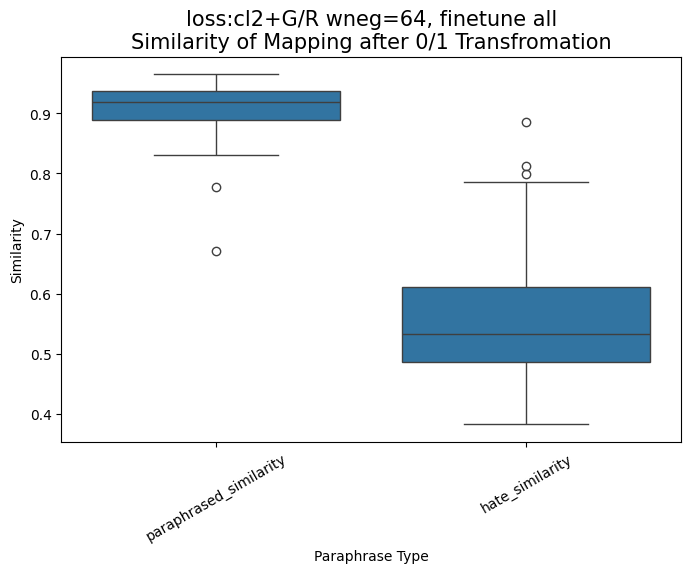

Complete!


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df_result = compute_mapping_similarity(model, tokenizer, sign_transform=True)

df_long = pd.melt(df_result[['paraphrased_similarity', 'hate_similarity']], 
                  var_name='Similarity Type', value_name='Similarity')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Similarity Type', y='Similarity', data=df_long)

plt.title(f"loss:cl2+G/R wneg=64, finetune all\nSimilarity of Mapping after 0/1 Transfromation", fontsize=15)
plt.xlabel('Paraphrase Type')
plt.ylabel('Similarity')
plt.xticks(rotation=30)

# 显示图表
plt.show()
print('Complete!')


### draw similarity boxplot between different original text


1225it [00:43, 28.30it/s]


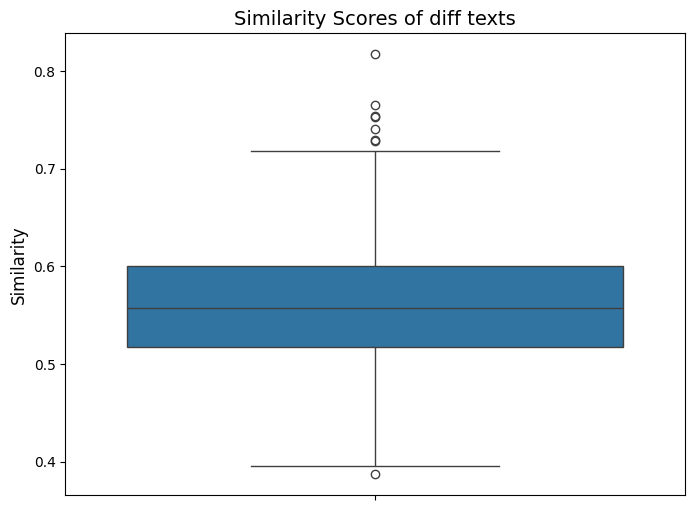

In [14]:
# draw similarity boxplot between different original text
import pandas as pd
from itertools import combinations

test_data_final = r'/mnt/data2/lian/projects/watermark/data/c4_test_final.csv'
df_test_final = pd.read_csv(test_data_final)

# Generate all unique pairs of rows from the "text" column
unique_pairs = combinations(df_test_final["text"], 2)

# Compute similarity for each pair and store results
results = []
for text1, text2 in tqdm(unique_pairs):
    similarity = _compute_mapping_similarity(text1, text2, model, tokenizer, sign_transform=True)
    results.append({"text1": text1, "text2": text2, "similarity": similarity})

# Convert results to a dataframe for better visualization
df_results = pd.DataFrame(results)

# Draw a boxplot for the 'similarity' column
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_results['similarity'])
plt.title('Similarity Scores of diff texts', fontsize=14)
plt.ylabel('Similarity', fontsize=12)
plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at /mnt/data2/lian/projects/watermark/SimCSE/result/my-sup-wm-simcse-roberta-sentiment-test and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

## try using LLM for embedding

In [4]:
import torch
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer

/mnt/data/lian/anaconda3/envs/watermark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data/lian/anaconda3/envs/watermark/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
from transformers.models.qwen2.modeling_qwen2 import Qwen2PreTrainedModel, Qwen2Model

class Qwen2ForCL(Qwen2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.model = Qwen2Model(config)
        self.map = TransformModel(input_dim=1536)



In [7]:
embed_model_name = "Alibaba-NLP/gte-Qwen2-1.5B-instruct"
embed_model = Qwen2ForCL.from_pretrained(embed_model_name).to('cuda')
# embed_model = AutoModel.from_pretrained(embed_model_name).to('cuda')
embed_tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
embed_model.eval


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]
Some weights of Qwen2ForCL were not initialized from the model checkpoint at Alibaba-NLP/gte-Qwen2-1.5B-instruct and are newly initialized: ['map.layers.0.bias', 'map.layers.0.weight', 'map.layers.1.fc.bias', 'map.layers.1.fc.weight', 'map.layers.2.fc.bias', 'map.layers.2.fc.weight', 'map.layers.3.bias', 'map.layers.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<bound method Module.eval of Qwen2ForCL(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151646, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
     

In [42]:
embed_model.device

device(type='cuda', index=0)

In [43]:
text = 'hi how are you'
input_ids = embed_tokenizer(text, return_tensors='pt').to('cuda')
outputs = embed_model(**input_ids, output_hidden_states=True, return_dict=True)  # (bs, seq_len, hidden_states)

In [44]:
outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'hidden_states'])

In [6]:
print(input_ids)
print(len(input_ids['input_ids'][0]))


{'input_ids': tensor([[6023, 1246,  525,  498]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
4


In [53]:
pooler_output = outputs['last_hidden_state']
print(pooler_output.shape)

torch.Size([1, 4, 1536])


In [8]:
embed_model_name = "Alibaba-NLP/gte-Qwen2-1.5B-instruct"
embed_model = AutoModel.from_pretrained(embed_model_name).to('cuda')
embed_tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
embed_model.eval

print(embed_model.num_parameters())
print(embed_model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


1543268864
Qwen2Model(
  (embed_tokens): Embedding(151646, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2SdpaAttention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        (rotary_emb): Qwen2RotaryEmbedding()
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((1536,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEm

In [19]:
embed_model.state_dict().keys()

odict_keys(['embed_tokens.weight', 'layers.0.self_attn.q_proj.weight', 'layers.0.self_attn.q_proj.bias', 'layers.0.self_attn.k_proj.weight', 'layers.0.self_attn.k_proj.bias', 'layers.0.self_attn.v_proj.weight', 'layers.0.self_attn.v_proj.bias', 'layers.0.self_attn.o_proj.weight', 'layers.0.mlp.gate_proj.weight', 'layers.0.mlp.up_proj.weight', 'layers.0.mlp.down_proj.weight', 'layers.0.input_layernorm.weight', 'layers.0.post_attention_layernorm.weight', 'layers.1.self_attn.q_proj.weight', 'layers.1.self_attn.q_proj.bias', 'layers.1.self_attn.k_proj.weight', 'layers.1.self_attn.k_proj.bias', 'layers.1.self_attn.v_proj.weight', 'layers.1.self_attn.v_proj.bias', 'layers.1.self_attn.o_proj.weight', 'layers.1.mlp.gate_proj.weight', 'layers.1.mlp.up_proj.weight', 'layers.1.mlp.down_proj.weight', 'layers.1.input_layernorm.weight', 'layers.1.post_attention_layernorm.weight', 'layers.2.self_attn.q_proj.weight', 'layers.2.self_attn.q_proj.bias', 'layers.2.self_attn.k_proj.weight', 'layers.2.self_

In [21]:
'lm_head.weight' in embed_model.state_dict().keys()

False

In [8]:
print(embed_model.num_parameters())
print(embed_model)

124647939
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

In [10]:
print(embed_model.num_parameters())
print(embed_model)

66362880
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (

In [27]:
model = TransformModel(input_dim=args.input_dim).to(device)
model

TransformModel(
  (layers): ModuleList(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1-2): 2 x ResidualBlock(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (relu): ReLU()
    )
    (3): Linear(in_features=512, out_features=384, bias=True)
  )
)